# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

# 1.Откройте файл с данными и изучите общую информацию
  

### открытие и чтение данных
Примечания:
Использовала метод data.info. 
Вижу в первую очередь проблему с разделителями.Попытка построить гистограмму (data.hist(figsize=(15, 20)))выдает ошибку. 
Появилась догадка, нужен разделитель sep='\t'. 
Данные разделились лучше, график построен.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

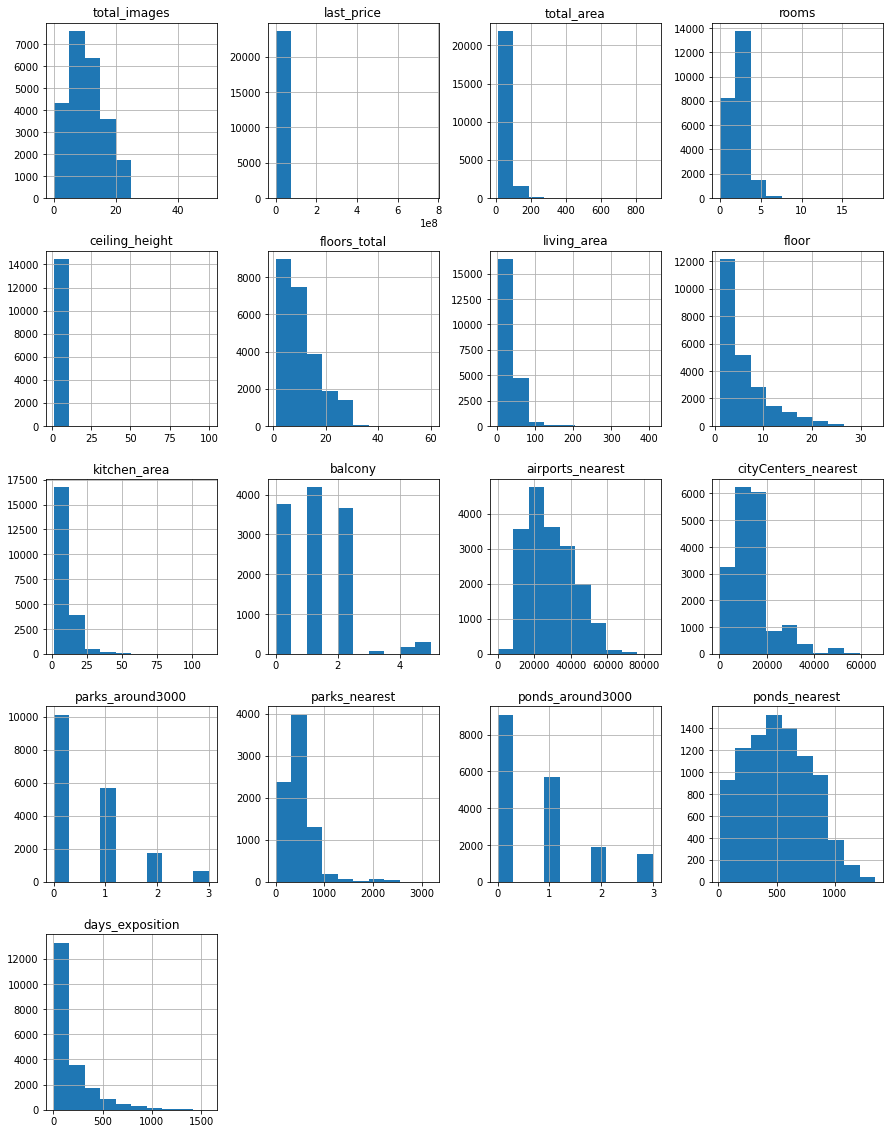

''

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
data =  pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
print(data.info())
print(data.head())
data.hist(figsize=(15, 20))
plt.show()
;

# 2. Предобработка данных



### замена пропусков
### изменение типов данных
По результатам data.info() предполагаю, что количество значений в столбце 23699, где меньше - вероятно пропуски.Провожу последовательную замену: 
1. ceiling_height — высота потолков (м) Хочется заменить средним. Но скорее всего, зависит от категории дома, и скорее всего есть типовые значения.Скорее всего, потерян при заполнении заявки как второстепенный параметр. Заменю пока no_data. Проверю, что заменилось методом data.info() и unique()

2. floors_total - аналогично. Скорее всего, потерян при заполнении заявки как второстепенный параметр. Заменю пока no_data. Проверю, что заменилось методом data.info() и unique()
dtype=object. Это нелогично, т.к. целое число. Беру на заметку.

3. living_area - аналогично. Проверяю. Не понимаю что на выходе в unique().
is_apartment - должен быть булев тип. Проверяю unique().там [nan False True] Бытовой опыт подсказывает - что аппартаменты - сравнительно редкий, но существенный параметр. Хочется заменить nan на False, предположение, что при заполнении заявки по умолчению False. И изменить тип данных с object на bool. Рискну так сделать. Методом,data.info() вижу что тип данных на bool поменялся сам. Значит оставляем)
4. kitchen_area - этот параметр вероятно аналогично, не заполнен, когда при заявке не были известны точные данные, как ceiling_height. Действую аналогично, заменяю на no_data.
balcony. Проверяю unique() и hist().Бытовой опыт подсказывает, что пропущенные - это скорее всего без балконов. При заполнении заявки вспомнить и назвать количество балконов не сложно. Количесто вариантов с без балконов наверно маловато, для северных населенных пунктов со старой застройкой балкон - не обязательная часть. Заменяю пропущенные на О.Проверяю на гистограмме, и понимаю, что пора менять object на int. Поменяла. Получилось тип int8 и внятная гистограмма, с большим количеством квартир без балконов.Без балконов примерно равно сумме всех других вариантов. Это может быть правдоподобно? Начинаю сомневаться. Но пока оставлю так.

locality_name. 49 пропущенных значений. Посмотрю что там в unique() Странно, что кто-то не мог назвать или оператор пропустил. Пока заменю на no_data, но может быть потом придется удалять такие строки. (Так как локалити ценнобразующая переменная? - а может это неверный стереотип?)

airports_nearest - там какие-то количественные переменные, скорее всего вычисленные по карте. Заменю пока пропуски на no_data, возможно потом придется вычислять

cityCenters_nearest - аналогично airports_nearest. 

parks_around3000. вероятно эти данные вносили пользователи, пропуски подразумевают, что нет парков (аналогично балконам). Меняем на 0 и тип данных на целое число.

parks_nearest - предположу, что географические данные.

ponds_nearest, с прудами аналогично паркам.

days_exposition - пропуски меняем на no_data, но возможно надо менять на максимальное значение во всем датасете. тк. отсутсвие данных может означать, что объект не продан. А может непроданный объект нерелевантен и его нужно будет исключить из датасета.

'last_price' и total_area перевожу в float


In [2]:
data['ceiling_height'] = data['ceiling_height'].fillna('no_data')
data['floors_total'] = data['floors_total'].fillna('no_data')
data['living_area'] = data['living_area'].fillna('no_data')
data['is_apartment'] = data['is_apartment'].fillna(False)
#print(data['is_apartment'].unique())
data['kitchen_area'] = data['kitchen_area'].fillna('no_data')
data['balcony'] = data['balcony'].fillna(0.0)
data['balcony'] = pd.to_numeric(data['balcony'],downcast="integer")
data['locality_name'] = data['locality_name'].fillna('no_data')
data['airports_nearest'] = data['airports_nearest'].fillna('no_data')
data = data.rename(columns={'cityCenters_nearest':'city_centers_nearest'})
data['parks_nearest'] = data['parks_nearest'].fillna('no_data')
data['parks_around3000'] = data['parks_around3000'].fillna(0.0)
data['parks_around3000'] = pd.to_numeric(data['parks_around3000'],downcast='signed')
data['ponds_nearest'] = data['ponds_nearest'].fillna('no_data')
data['ponds_around3000'] = data['ponds_around3000'].fillna(0.0)
data['ponds_around3000'] = pd.to_numeric(data['ponds_around3000'],downcast='signed')
data['days_exposition'] = data['days_exposition'].fillna('no_data')
data['last_price'] = pd.to_numeric(data['last_price'],downcast='signed',errors='coerce')
data['total_area'] = pd.to_numeric(data['total_area'])
data['first_day_exposition']= pd.to_datetime(data['first_day_exposition'])
data['ceiling_height'] = pd.to_numeric(data['ceiling_height'],errors='coerce')
data['floors_total'] = pd.to_numeric(data['floors_total'],downcast='signed',errors='coerce')
data['living_area'] = pd.to_numeric(data['living_area'],errors='coerce')
data['kitchen_area'] = pd.to_numeric(data['kitchen_area'],errors='coerce')#kitchen_area
data['airports_nearest'] = pd.to_numeric(data['airports_nearest'],errors='coerce')#airports_nearest
data['city_centers_nearest'] = pd.to_numeric(data['city_centers_nearest'],errors='coerce')#city_centers_nearest
data['ponds_nearest'] = pd.to_numeric(data['ponds_nearest'],errors='coerce')#ponds_nearest
data['parks_nearest'] = pd.to_numeric(data['parks_nearest'],errors='coerce')#parks_nearest
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int32         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

Произведена замена пропусков и изменен формат данных в тех столбцах, где была гипотеза о природе пропусков

### поиск неявных дубликатов. 
Выгрузила список методом unique(), len=365.Поиск вела в программе Word. Основная масса неявных дубликатов связана со словом "поселок/посёлок". Но не только. Есть пары и тройки дубликатов не только с этим признаком. При совпадении названий деревни и поселка (напр. Щеглово) принимаю решение считать разными объектами.Также принимаю решение считать разными объектами новое\старое\никакое и верхнее\нижнее\никакое. На карту за допинформацие не иду, т.к. задание учебное с дедлайном, и я боюсь что эта часть займет очень много времени. Нашла неявные дубликаты и произвела замену последовательно по списку, в итоге len = 316

In [3]:


print('проверка на явные дубликаты:',data.duplicated().sum())

data = data.replace('городской посёлок Янино-1', 'городской поселок Янино-1')
data = data.replace('посёлок Мурино' , 'Мурино')
data = data.replace('деревня Кудрово', 'Кудрово')
data = data.replace('посёлок городского типа Лебяжье', 'поселок городского типа Лебяжье')
data = data.replace('поселок городского типа Кузьмоловский','посёлок городского типа Кузьмоловский')
data = data.replace('посёлок Аннино','поселок Аннино')
data = data.replace('посёлок городского типа Красный Бор', 'поселок городского типа Красный Бор')
data = data.replace('посёлок Новый Свет', 'поселок Новый Свет') 
data = data.replace('посёлок Бугры','поселок Бугры')
data = data.replace('городской посёлок Рощино','посёлок городского типа Рощино')
data = data.replace('поселок городского типа Рощино','посёлок городского типа Рощино')
data = data.replace('Никольское', 'село Никольское')
data = data.replace('посёлок Усть-Луга','поселок Усть-Луга')
data = data.replace('городской посёлок Павлово','посёлок городского типа Павлово')
data = data.replace('посёлок Победа', 'поселок Победа') 
data = data.replace('посёлок Терволово', 'поселок Терволово') 
data = data.replace('поселок городского типа Советский', 'городской посёлок Советский') 
data = data.replace('посёлок Петровское','поселок Петровское')  
data = data.replace('посёлок Мичуринское', 'поселок Мичуринское') 
data = data.replace('посёлок городского типа Токсово','поселок городского типа Токсово')
data = data.replace('посёлок городского типа Вырица', 'поселок городского типа Вырица')
data = data.replace('посёлок Тельмана', 'поселок Тельмана') 
data = data.replace('городской посёлок Лесогорский','поселок городского типа Лесогорский')
data = data.replace('поселок городского типа имени Свердлова','посёлок городского типа имени Свердлова') 
data = data.replace('поселок Рябово', 'посёлок городского типа Рябово') 
data = data.replace('поселок городского типа Рябово', 'посёлок городского типа Рябово') 
data = data.replace('посёлок Поляны','поселок Поляны')
data = data.replace( 'городской посёлок Мга','посёлок городского типа Мга')  
data = data.replace('поселок Ильичёво','посёлок Ильичёво')
data = data.replace('поселок станции Вещево','посёлок при железнодорожной станции Вещево')
data = data.replace('посёлок Гаврилово', 'поселок Гаврилово') 
data = data.replace('городской посёлок Назия','поселок городского типа Назия')
data = data.replace('посёлок Старая Малукса', 'поселок Старая Малукса') 
data = data.replace('посёлок Сапёрный', 'посёлок Сапёрное')
data = data.replace('поселок станции Приветнинское','посёлок при железнодорожной станции Приветнинское')
data = data.replace('поселок Мельниково','посёлок Мельниково')
data = data.replace('поселок Стеклянный','посёлок Стеклянный') 
data = data.replace('поселок городского типа Форносово','посёлок городского типа Форносово')
data = data.replace('посёлок Сумино','поселок Сумино')
data = data.replace('посёлок Возрождение','поселок Возрождение')
data = data.replace('поселок Лисий Нос','посёлок Лисий Нос') 
data = data.replace('поселок Жилгородок','посёлок Жилгородок') 
data = data.replace('поселок Громово','посёлок станции Громово') 
data = data.replace('посёлок Коробицыно','поселок Коробицыно')
data = data.replace('посёлок Кобралово' ,'поселок Кобралово') 
data = data.replace('поселок Лесное','коттеджный посёлок Лесное')
data = data.replace('поселок Перово','посёлок Перово') 
data = data.replace('городской поселок Большая Ижора','поселок городского типа Большая Ижора') 
data = data.replace('посёлок Пансионат Зелёный Бор','поселок Пансионат Зелёный Бор')

проверка на явные дубликаты: 0


добавлена проверка на явные дубликаты и проведен ручной поиск и замена неявных дубликатов: список уникальных названий населенных пунктов сократился с 365 до 316
    

### поиск редких и выбивающихся значений. 
последовательно проверяю все столбцы :mean() median () max() min ()
по 'total_area' вопросов нет
по 'rooms'вопросов нет
по ceiling_height - аномалии. В задании есть наводка как обрабатывать.  Применяю data.groupby, к данным много вопросов. Если рассматривать на гистограмме на разных интервалах, 1) основаная массма данных по высотре потолка - 2-4 метра 2) видно что есть "всплеск" странных значений с 20 - 27,5 метров. Что вероятно действительно.можно поделить на 10. Но непонятно, что делать с единичными  случаями потолков 1, 1.20, 11.75 и с другой стороны от среднего 10 метров, 15 метров, 100 метров? 
Думаю надо сделать новый столбец с релевантными значениями потолка 'ceiling_normal'. А старый сохранить на всякий случай, вдруг какой-то уникальный жилищный фонд. В диапазоне 20-27,5 метров поделить как в условии. Реалистичным диапазоном высоты считаю 2-5 метров. Остальные аномалии заменю на среднее. Это неверно по отношению к отдельному объекту (у него действительно могут быть другие характеристики) но на общую статистику должно оказать нормализующий эффект. 
по floors_total - 52 этажа и 60 этажей в Питере возможны как аппартаменты(?) Не буду исключать эти значения пока, но возьму на заметку. 
также обнаружено аномальное значение минимальная цена 12190 в 'last_price'
нахожу с помощью query что это объект
оказывается что двухкомнотная квартира в Питере. Что недостоверно. 
следующие по величине цены 430000 - 2 объекта в области, поселок станции и еще что-то. Такую цену считаю возможной. 
Заменяю значение 12190 на медиану. 

<div class="alert alert-info">Дополнено поиском и заменой аномальной цены в 'last_price'</div>

манимальная цена продажи 12190
last_price
12190        1
430000       2
440000       1
450000       4
470000       3
            ..
300000000    1
330000000    1
401300000    1
420000000    1
763000000    1
Name: locality_name, Length: 2978, dtype: int64


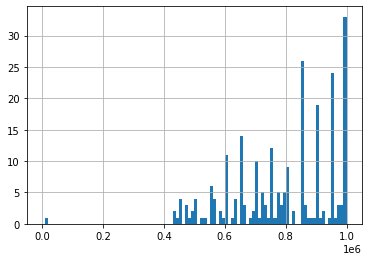

      total_images  last_price  total_area first_day_exposition  rooms  \
8793             7       12190       109.0           2019-03-20      2   

      ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
8793            2.75          25.0         32.0     25         False  ...   

      balcony    locality_name  airports_nearest  city_centers_nearest  \
8793        0  Санкт-Петербург           36421.0                9176.0   

     parks_around3000  parks_nearest  ponds_around3000  ponds_nearest  \
8793                1          805.0                 0            NaN   

      days_exposition  ceiling_normal  
8793              8.0            2.75  

[1 rows x 23 columns]
       total_images  last_price  total_area first_day_exposition  rooms  \
14911             5      430000        54.0           2018-06-26      2   
17456             7      430000        30.4           2019-04-22      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  

In [4]:
data['ceiling_normal'] = data['ceiling_height'] 
#data['ceiling_normal'] = data.loc[2<=data'ceiling_normal'<=5,'ceiling_normal']
data.loc[data['ceiling_normal']>= 20, 'ceiling_normal'] = data.loc[data['ceiling_normal'] >= 20, 'ceiling_normal'] / 10                                  
data.loc[data['ceiling_normal']>= 5, 'ceiling_normal'] = data['ceiling_normal'].mean() 
data.loc[data['ceiling_normal']<= 2, 'ceiling_normal'] = data['ceiling_normal'].mean()
#print(data['ceiling_normal'].unique())
print('манимальная цена продажи',data['last_price'].min())
data['last_price'].hist(bins=100,range=(0, 1000000))
print(data.groupby('last_price')['locality_name'].count())
#data_low['last_price']=(data_low['total_area']*114849)
plt.show()
data_low = data.query('last_price == 12190')
print(data_low)
data_low2 = data.query('last_price == 430000')
print(data_low2)
data.loc[data['last_price']<= 400000, 'last_price'] = data['last_price'].median()

print(data.info())
#print(data.head())

<div class="alert alert-info">проверила дополнительно аномальные случаи в last_price и нашла проблему
</div>

<div class="alert alert-info">Если last_price это вопрос про int и float? Первоначально оставила float, т.к он не против природы явления. а может копейки от каких-нибуль кадастровых формул при продаже банками, при пересчете валют итд? Поменяла на int. Но вопрос навел на мысли проверить минимальные значения. Но позникла идея пристально посмотреть значениия в этом слолбце. Минимальная цена столбце  12190.0, не очень достоверная цена для недвижимости ... а может избушка...? Я попробую сделать выборку query... А это двушка в 9 км от центра Питера на 25-м этаже 25 этажки проданная через 8 дней после подачи объяления - и я даже не знаю, тут 2 нуля потеряны или три?Т.к. средняя цена за метр в Питере, как мы узнали равна 114849. Поэтому наверно объект был скорее 12 млн, но точно не известно. Заменю на медиану. </div>

# 3 Посчитайте и добавьте в таблицу новые столбцы

### добавление новых столбцов: 
1. Цена за квадратный метр 'price_per_m' считаю как цена одного квадратного метра = цена / общий метраж. 
2. Добавляю 'week_day' 'year' 'month'
3. Этаж 'flow_categ'определяю в категорию с помощью функции 
4. Расстояние в километрах 'from_city_centers'


In [5]:
#data ['total_area'].unique()
#print (data['total_area'].min())

data['price_per_m'] = data['last_price']/data['total_area']
data['week_day'] = data['first_day_exposition'].dt.weekday
data['year'] = data['first_day_exposition'].dt.year
data['month'] = data['first_day_exposition'].dt.month
def flow_categ(row):
    floor=row['floor']
    floors_total= row['floors_total'] 
    if  floor ==1:  
            return 'первый'
    if floor==floors_total: 
            return 'последний'
    else: 
            return 'другой'

data['flow_categ']=data.apply(flow_categ, axis=1)  

data['from_city_centers']= round(data['city_centers_nearest']/1000)
data['from_city_centers'].dropna()
data['from_city_centers']=pd.to_numeric(data['from_city_centers'],downcast='signed', errors='coerce')
print(data.info())
print(data.head())





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

# 4 Проведите исследовательский анализ данных

### анализ данных по категориям (столбцам)

1. Для цены объекта захотелось построить вторую прицельную диаграмму в р-не распределения большинства значений 10000, 10000000, получилась хорошая, картинка нормального распределения (Гаусс?)

2. Высота потолков у меня уже в новом столбце ceiling_normal

3. Для категориальной переменной "тип этажа" была построена диаграмма-пирог. 

4. Общее количество этажей в доме - два пика, пятиэтажки и десятиэтажки, достоверно. Пятиэтажки в самом большом количестве представлены. Владельцы вероятно стремятся их продать. Предложение может быть больше спроса, беру на заметку, возможно это влияет на цену. 

5. День и месяц публикации объявления - поняла задание как день недели и месяц, чтобы проанализировать изменение активности по дням недели и сезонную. В выходные меньше - у риэлторов выходные. По сезонности - май и (декабрь-январь) меньше активности (больше праздников)

6.'days_exposition' - в предобработке данных я не пришла к решению, как воспринимать пропуски и чем заполнять. Поэтому формат меняю только сейчас. Подробнее строю в интервале 0-200. Вижу вспелски до и после 50 дней. Что бы это значило? Сроки предпоплаченных объявлений, рекламы? Пока такая версия. Строю ящик с усами. И вызываю числовое описание. 
count    20518.000000
mean       180.888634 - среднее очень сильно выбивается за счет выбросов в большие значение вообще не показатель здесь
std        219.727988
min          1.000000
25%         45.000000 - начало нормального срока продажи (ниже - быстрые). Вспоминаю про "всплеск" продаж примерно в этом р-не. Думаю это как-то связано с рекламной политикой и ценнообразованием в профессиональном сегменте. (риэлторы сообщают, что быстро не продается, нужно снижать цену, давать рекламу итд.- это все в области предположений, конечно)
50%         95.000000 - медиана, более релевантна,чем среднее
75%        232.000000 - верхняя граница нормального срока продажи (выше - долгие)
max       1580.000000
В целом тут не Гаусс, что что-то более сложное. Вероятность продажи квартиры падает, по мере срока ее размещения. Но вероятно применяются допактивности, т.к. есть всплески. 
Вторая догадка про вспеск в 45 дней - это срок завершения каких-либо регистрационых действий (квартиры нашедшей покупателя почти сразу). 
Хотелось бы понимать, на каком этапе снимаются объявления - по факту договора, перехода права итд. 





Общая площадь: | минимум 12.0 | максимум: 900.0 | медиана: 52.0 | среднее: 60.34865099793241 AxesSubplot(0.125,0.125;0.775x0.755)


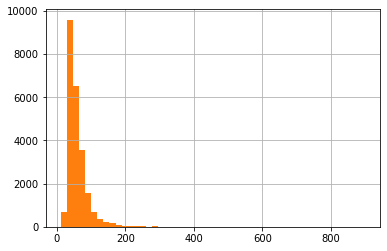

Жилая площадь: | минимум 2.0 | максимум: 409.7 | медиана: 30.0 | среднее: 34.457852427601395


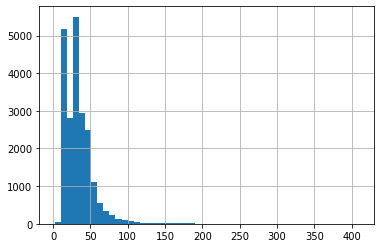

Площадь кухни: | минимум 1.3 | максимум: 112.0 | медиана: 9.1 | среднее: 10.569807198543485


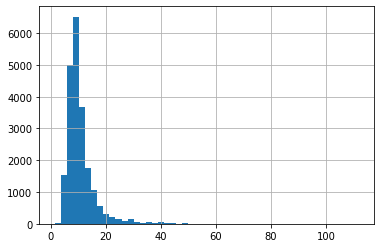

Цена объекта: | минимум 430000.0 | максимум: 763000000.0 | медиана: 4650000.0 | среднее: 6541744.46799443


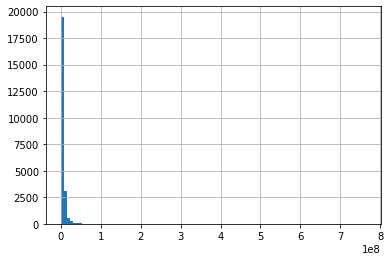

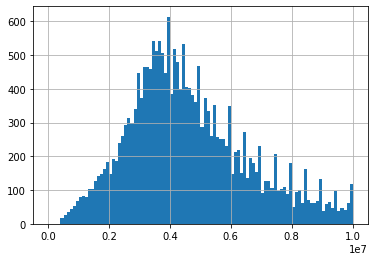

Количество комнат: | минимум 0 | максимум: 19 | медиана: 2.0 | среднее: 2.070635891809781


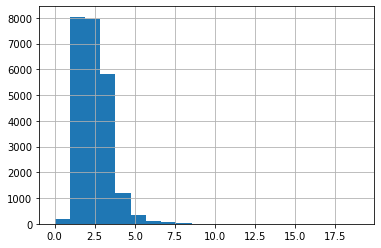

Высота потолков: | минимум 2.2 | максимум: 4.9 | медиана: 2.65 | среднее: 2.7257168024788343


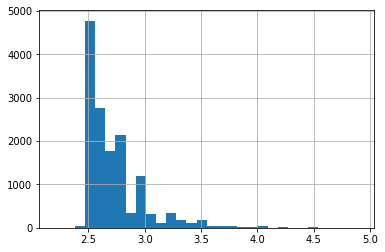

Этаж квартиры: | минимум 1 | максимум: 33 | медиана: 4.0 | среднее: 5.892358327355584


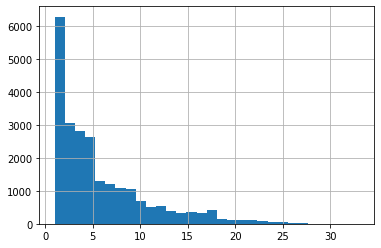

Тип этажа квартиры: ['другой' 'первый' 'последний']
flow_categ
другой       17446
первый        2917
последний     3336
Name: flow_categ, dtype: int64
Общее количество этажей в доме: | минимум 1.0 | максимум: 60.0 | медиана: 9.0 | среднее: 10.67382374115953


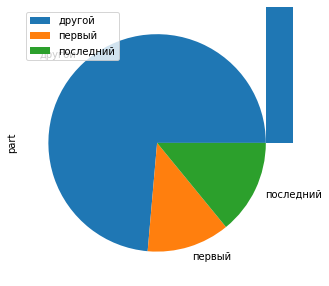

Расстояние до центра города в метрах: | минимум 181.0 | максимум: 65968.0 | медиана: 13098.5 | среднее: 14191.277832783278


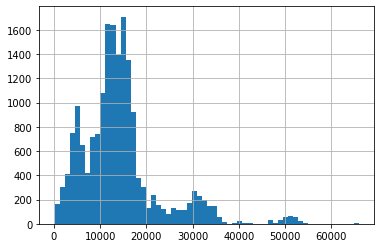

Расстояние до ближайшего аэропорта: | минимум 0.0 | максимум: 84869.0 | медиана: 26726.0 | среднее: 28793.67219254282


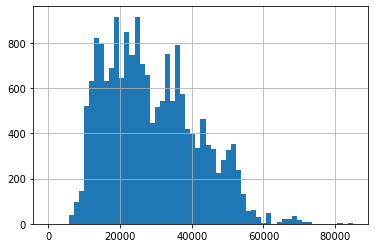

Расстояние до ближайшего парка: | минимум 1.0 | максимум: 3190.0 | медиана: 455.0 | среднее: 490.80455501918556


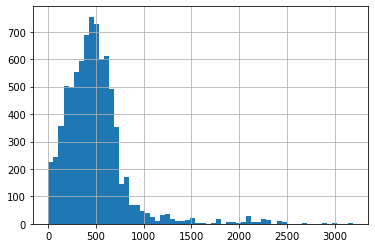

Расстояние до ближайшего парка: | минимум 1.0 | максимум: 3190.0 | медиана: 455.0 | среднее: 490.80455501918556


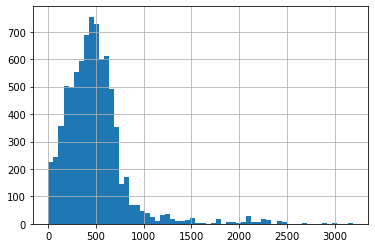

День публикации объявления [3 1 4 0 2 6 5]


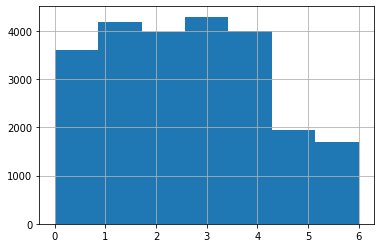

Месяц публикации объявления [ 3 12  8  7  6  9 11  4  5  2  1 10]


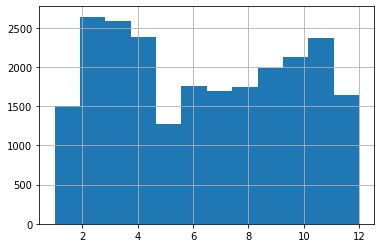

Срок до продажи квартиры: | минимум 1.0 | максимум: 1580.0 | медиана: 95.0 | среднее: 180.88863436982163


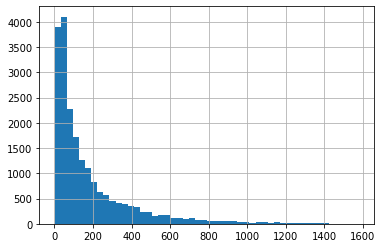

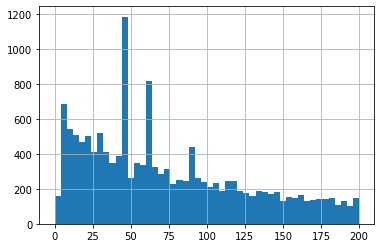

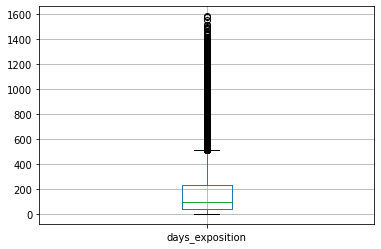

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-nu

In [6]:
import matplotlib.pyplot as plt
print ('Общая площадь:','| минимум', data['total_area'].min(),
'| максимум:', data['total_area'].max(),
'| медиана:', data['total_area'].median(),
'| среднее:',data['total_area'].mean(),data['total_area'].hist(bins=50))
data['total_area'].hist(bins=50)
plt.show()
print ('Жилая площадь:','| минимум', data['living_area'].min(),
'| максимум:', data['living_area'].max(),
'| медиана:', data['living_area'].median(),
'| среднее:',data['living_area'].mean())
data['living_area'].hist(bins=50)
plt.show()
print ('Площадь кухни:','| минимум', data['kitchen_area'].min(),
'| максимум:', data['kitchen_area'].max(),
'| медиана:', data['kitchen_area'].median(),
'| среднее:',data['kitchen_area'].mean())
data['kitchen_area'].hist(bins=50)
plt.show()
print ('Цена объекта:','| минимум', data['last_price'].min(),
'| максимум:', data['last_price'].max(),
'| медиана:', data['last_price'].median(),
'| среднее:',data['last_price'].mean())
data['last_price'].hist(bins=100)
plt.show()
data['last_price'].hist(bins=100,range=(10000, 10000000))
plt.show()
print ('Количество комнат:','| минимум', data['rooms'].min(),
'| максимум:', data['rooms'].max(),
'| медиана:', data['rooms'].median(),
'| среднее:',data['rooms'].mean())
data['rooms'].hist(bins=20)
plt.show()
print ('Высота потолков:','| минимум', data['ceiling_normal'].min(),
'| максимум:', data['ceiling_normal'].max(),
'| медиана:', data['ceiling_normal'].median(),
'| среднее:',data['ceiling_normal'].mean())
data['ceiling_normal'].hist(bins=30)
plt.show()
print ('Этаж квартиры:','| минимум', data['floor'].min(),
'| максимум:', data['floor'].max(),
'| медиана:', data['floor'].median(),
'| среднее:',data['floor'].mean())
data['floor'].hist(bins=30)
plt.show()
print ('Тип этажа квартиры:', data['flow_categ'].unique())
print(data.groupby('flow_categ')['flow_categ'].count())
df = pd.DataFrame({'part': [17446, 2917 , 3336],
                   },
                  index=['другой', 'первый', 'последний'])
plot = df.plot.pie(y='part', figsize=(5, 5))
#flow_categ
#другой       17446
#первый        2917
#последний     3336
#data.plot(y='flow_categ',kind='bar')
#data['flow_categ'].plot(kind='pie')
#plt.show()
print ('Общее количество этажей в доме:','| минимум', data['floors_total'].min(),
'| максимум:', data['floors_total'].max(),
'| медиана:', data['floors_total'].median(),
'| среднее:',data['floors_total'].mean())
data['floors_total'].hist(bins=60)
plt.show()
print ('Расстояние до центра города в метрах:','| минимум', data['city_centers_nearest'].min(),
'| максимум:', data['city_centers_nearest'].max(),
'| медиана:', data['city_centers_nearest'].median(),
'| среднее:',data['city_centers_nearest'].mean())
data['city_centers_nearest'].hist(bins=60)
plt.show()
print ('Расстояние до ближайшего аэропорта:','| минимум', data['airports_nearest'].min(),
'| максимум:', data['airports_nearest'].max(),
'| медиана:', data['airports_nearest'].median(),
'| среднее:',data['airports_nearest'].mean())
data['airports_nearest'].hist(bins=60)
plt.show()
print ('Расстояние до ближайшего парка:','| минимум', data['parks_nearest'].min(),
'| максимум:', data['parks_nearest'].max(),
'| медиана:', data['parks_nearest'].median(),
'| среднее:',data['parks_nearest'].mean())
data['parks_nearest'].hist(bins=60)
plt.show()
print ('Расстояние до ближайшего парка:','| минимум', data['parks_nearest'].min(),
'| максимум:', data['parks_nearest'].max(),
'| медиана:', data['parks_nearest'].median(),
'| среднее:',data['parks_nearest'].mean())
data['parks_nearest'].hist(bins=60)
plt.show()
print ('День публикации объявления',data['week_day'].unique())
data['week_day'].hist(bins=7)
plt.show()
print ('Месяц публикации объявления',data['month'].unique())
data['month'].hist(bins=12)
plt.show()
data['days_exposition'].dropna()
data['days_exposition']= pd.to_numeric(data['days_exposition'],downcast='signed',errors='coerce')
print ('Срок до продажи квартиры:','| минимум', data['days_exposition'].min(),
'| максимум:', data['days_exposition'].max(),
'| медиана:', data['days_exposition'].median(),
'| среднее:',data['days_exposition'].mean())
data['days_exposition'].hist(bins=50)
plt.show()
data['days_exposition'].hist(bins=50,range=(0, 200))
plt.show()
data.boxplot(column='days_exposition')
plt.show()
print(data['days_exposition'].describe())

data.info()


### рассчет взаимосвязей данных и анализ выявленных взаимосвязей 
Примечания: 
Для предварительно поиска взаимосвязей с ценой объекта построим матрицу корреляций для всего. 
Выпишем те значения, где наблюдается положительная корреляция 
total_area - 0.653675, есть но не очень высокая
living_area - 0.566492, есть, но слабая
kitchen_area - 0.519869 есть, но слабая
price_per_m - 0.736499 корреляция хорошая, но это вторичные данные рассчитанные на основе last_price. Эту взаимосвязь мы сделали сами.
Для исследования остаются только первые 3. Построим для них диаграммы рассеивания.  
Для total_area, living_area, kitchen_area картины очень похожие - диаграммы иллюстрирует зависимость, но по мере увеличения цены объекта связь ослабевает. Резкий уголок а начале - (при небольших габаритах квартир кажлый метр на счету -?), а дальше графики буквально идут вдоль оси Х. Связь есть, но не сильная. Что и по коэффициенту корреляции можно понять. 

In [7]:
print(data.corr()) 



                      total_images  last_price  total_area     rooms  \
total_images              1.000000    0.104465    0.115352  0.099288   
last_price                0.104465    1.000000    0.653704  0.363344   
total_area                0.115352    0.653704    1.000000  0.758344   
rooms                     0.099288    0.363344    0.758344  1.000000   
ceiling_height           -0.001987    0.085431    0.095490  0.054457   
floors_total              0.010427   -0.006944   -0.075774 -0.228215   
living_area               0.104780    0.566494    0.939537  0.845977   
floor                     0.031340    0.026646   -0.024754 -0.150862   
is_apartment              0.010532    0.026957    0.029633  0.000399   
studio                   -0.029303   -0.025363   -0.072653 -0.147286   
open_plan                -0.024407   -0.008803   -0.034885 -0.087500   
kitchen_area              0.104756    0.519987    0.609121  0.269945   
balcony                   0.048903    0.008548    0.009941 -0.01

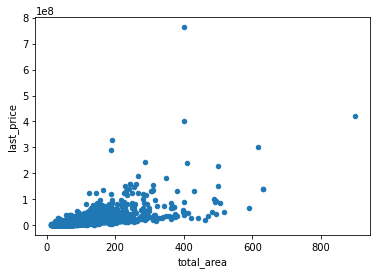

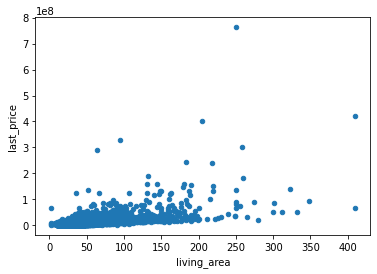

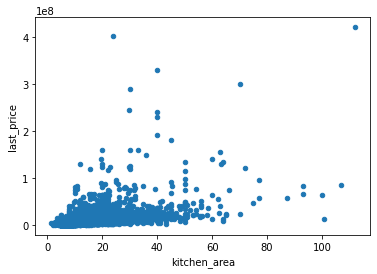

In [8]:
data.plot(x='total_area', y='last_price', kind='scatter')
plt.show()
data.plot(x='living_area', y='last_price', kind='scatter')
plt.show()
data.plot(x='kitchen_area', y='last_price', kind='scatter')
plt.show()

### визуализация других взаимосвязей
По матрице корреляций не обнаружена корреляция между ценой недвижимости и такими характеристиками, как: количество комнат. Попробую проанализировать ее визуально.Вижу какую-то аномалию с 12-ти комнатными квартирами. Интересно, что это, применяю query


       Медиана (цена сделки)
rooms                       
0                  2700000.0
1                  3600000.0
2                  4770169.0
3                  6200000.0
4                  9000000.0
5                 14000000.0
6                 19000000.0
7                 24900000.0
8                 23095000.0
9                 23750000.0
10                23000000.0
11                25250000.0
12               420000000.0
14                26829500.0
15                65000000.0
16                28500000.0
19                32250000.0


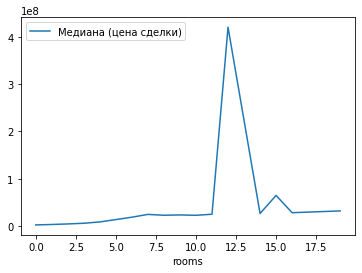

       total_images   last_price  total_area first_day_exposition  rooms  \
19540             8  420000000.0       900.0           2017-12-06     12   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
19540             2.8          25.0        409.7     25         False  ...   

       ponds_around3000  ponds_nearest  days_exposition  ceiling_normal  \
19540                 2          318.0            106.0             2.8   

         price_per_m  week_day  year  month  flow_categ  from_city_centers  
19540  466666.666667         2  2017     12   последний                8.0  

[1 rows x 29 columns]


In [9]:
data_pivot_rooms=data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = ['median'])
data_pivot_rooms.columns = ['Медиана (цена сделки)']
print(data_pivot_rooms)
data_pivot_rooms.plot(y='Медиана (цена сделки)')
plt.show()
data_wow = data.query('rooms == 12')
print(data_wow)



### рассчет взаимосвязей с категориальными переменными
Примечания: 
В матрице корреляций технически не возможна информация о связи с категориальной переменной (день недели, тип этажа)
Года, месяцы и дни недели выраженные числами позволяют производить рассчеты, но по сути они не количественные, а категориальные переменные (имена) распределенные по установленным правилам.
Применю в этом случае метод groupby() На week_day зависимости не наблюдается, т.к и с чего бы ей быть. На данных по месяцам зависимость также не выразительная. А вот по годам есть. 
2014    7700000.0
2015    5350000.0
2016    4550000.0
2017    4500000.0
2018    4550000.0
2019    5050000.0
Нарисум гистограмму. 

На категории этажа возможна, проверим. 
другой       4850000.
первый       3900000.
последний    4300000.
Да, пожалуй другой все-таки больше ценится, чем первый или последний. Я брала медиану, а не среднее, т.к. выборка в большим количеством выбросов в крупных значениях, а для общего массива данных это не так важно. 

In [10]:

print(data.groupby('week_day')['last_price'].median())
print(data.groupby('year')['last_price'].median())
print(data.groupby('month')['last_price'].median())
print(data.groupby('flow_categ')['last_price'].median())
#data.info()


week_day
0    4650000.0
1    4730000.0
2    4700000.0
3    4650000.0
4    4585000.0
5    4555000.0
6    4550000.0
Name: last_price, dtype: float64
year
2014    7700000.0
2015    5350000.0
2016    4550000.0
2017    4500000.0
2018    4550000.0
2019    5050000.0
Name: last_price, dtype: float64
month
1     4600000.0
2     4650000.0
3     4650000.0
4     4800000.0
5     4515000.0
6     4400000.0
7     4650000.0
8     4570000.0
9     4700000.0
10    4570000.0
11    4700000.0
12    4700000.0
Name: last_price, dtype: float64
flow_categ
другой       4850000.0
первый       3900000.0
последний    4300000.0
Name: last_price, dtype: float64


<div class="alert alert-info">то же самое через сводную таблицу и с графиками</div>


      Медиана (цена сделки)  Cреднее (цена сделки)
year                                              
2014              7700000.0           1.208714e+07
2015              5350000.0           8.572833e+06
2016              4550000.0           6.827912e+06
2017              4500000.0           6.585729e+06
2018              4550000.0           5.950966e+06
2019              5050000.0           6.783999e+06


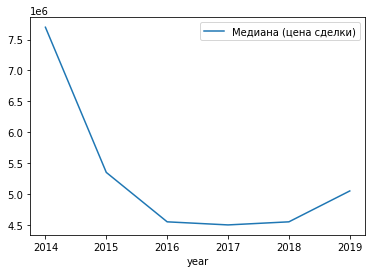

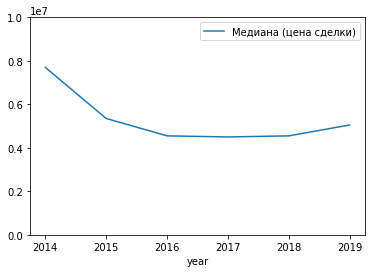

          Медиана (цена сделки)  Cреднее (цена сделки)
week_day                                              
0                     4650000.0           6.511613e+06
1                     4730000.0           6.394233e+06
2                     4700000.0           6.629137e+06
3                     4650000.0           6.708663e+06
4                     4585000.0           6.372131e+06
5                     4555000.0           6.976804e+06
6                     4550000.0           6.246180e+06


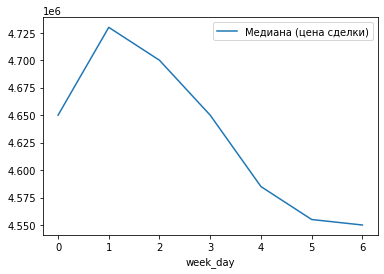

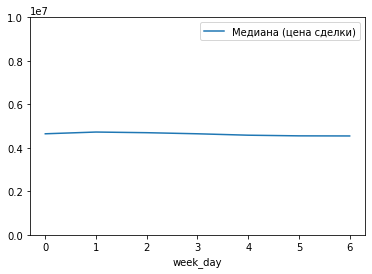

       Медиана (цена сделки)  Cреднее (цена сделки)
month                                              
1                  4600000.0           6.668233e+06
2                  4650000.0           6.468500e+06
3                  4650000.0           6.361068e+06
4                  4800000.0           6.737198e+06
5                  4515000.0           6.600435e+06
6                  4400000.0           6.310269e+06
7                  4650000.0           6.649337e+06
8                  4570000.0           6.350233e+06
9                  4700000.0           6.825470e+06
10                 4570000.0           6.235013e+06
11                 4700000.0           6.461363e+06
12                 4700000.0           7.011731e+06


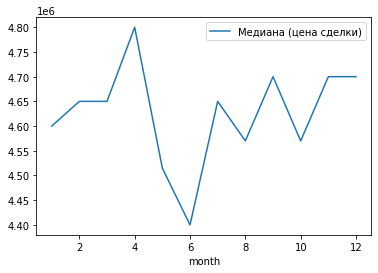

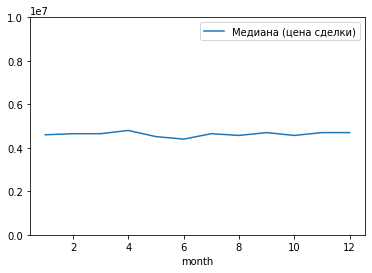

            Медиана (цена сделки)  Cреднее (цена сделки)
flow_categ                                              
другой                  4850000.0           6.675444e+06
первый                  3900000.0           4.803560e+06
последний               4300000.0           7.362415e+06


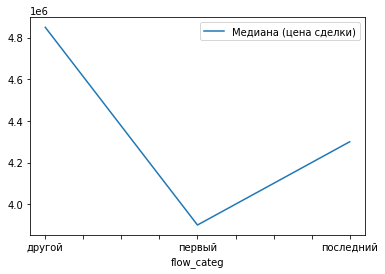

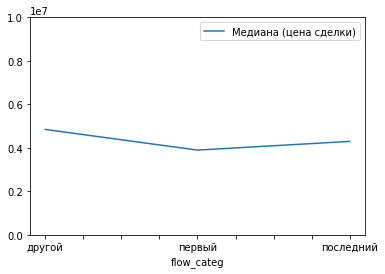

In [11]:
import matplotlib.pyplot as plt
data_pivot_year=data.pivot_table(index = 'year', values = 'last_price', aggfunc = ['median','mean'])
data_pivot_year.columns = ['Медиана (цена сделки)', 'Cреднее (цена сделки)']
print(data_pivot_year)
data_pivot_year.plot( y='Медиана (цена сделки)')
plt.show()
data_pivot_year.plot( y='Медиана (цена сделки)',ylim=(0, 10000000))
plt.show()
data_pivot_week=data.pivot_table(index = 'week_day', values = 'last_price', aggfunc = ['median','mean'])
data_pivot_week.columns = ['Медиана (цена сделки)', 'Cреднее (цена сделки)']
print(data_pivot_week)
data_pivot_week.plot( y='Медиана (цена сделки)')
plt.show()
data_pivot_week.plot( y='Медиана (цена сделки)',ylim=(0, 10000000))
plt.show()
data_pivot_month=data.pivot_table(index = 'month', values = 'last_price', aggfunc = ['median','mean'])
data_pivot_month.columns = ['Медиана (цена сделки)', 'Cреднее (цена сделки)']
print(data_pivot_month)
data_pivot_month.plot( y='Медиана (цена сделки)')
plt.show()
data_pivot_month.plot( y='Медиана (цена сделки)',ylim=(0, 10000000))
plt.show()
data_pivot_flow_categ=data.pivot_table(index = 'flow_categ', values = 'last_price', aggfunc = ['median','mean'])
data_pivot_flow_categ.columns = ['Медиана (цена сделки)', 'Cреднее (цена сделки)']
print(data_pivot_flow_categ)
data_pivot_flow_categ.plot( y='Медиана (цена сделки)')
plt.show()
data_pivot_flow_categ.plot( y='Медиана (цена сделки)',ylim=(0, 10000000))
plt.show()


<div class="alert alert-info"> Cначала строю графики по умолчению, потом убираю драматизм с графиков про цену</div>

### задача: про пункты с наибольшим количеством объявлений
Примечания:
построила сводную таблицу, отсортировала, вижу списке из 10 
                   Количество продаж  Cредняя цена за M2
locality_name                                           
Санкт-Петербург                15721       114849.008794
Мурино                           556        86178.443998
Кудрово                          472        95324.930544
посёлок Шушары                   440        78677.364217
Всеволожск                       398        68654.473986
Пушкин                           369       103125.819291
Колпино                          338        75424.579098
посёлок Парголово                327        90175.913458
Гатчина                          307        68746.146763
Выборг                           237        58141.909153
Если в задаче найти самую высокую и низкую цену в списке из этих 10:
самая высокая: Санкт-Петербург                15721       114849.008794
самая низкая: Выборг                           237        58141.909153

Повторила аналогичные вычисления но не по среднему, а по медиане.

In [12]:
#sorted_data = df.sort_values(by='column', ascending=False)
#print(data.groupby('locality_name')['last_price'].count())
#rint(data.groupby('flow_categ')['last_price'].median())
data_pivot1 = data.pivot_table(index = 'locality_name', values = 'price_per_m', aggfunc = ['count','mean'])
data_pivot1.columns = ['Количество продаж', 'Cредняя цена за M2']
print(data_pivot1)
sorted_data1 = data_pivot1.sort_values(by='Количество продаж', ascending=False)
print(sorted_data1.head(10))
data_pivot11 = data.pivot_table(index = 'locality_name', values = 'price_per_m', aggfunc = ['count','median'])
data_pivot11.columns = ['Количество продаж', 'Cредняя цена за M2']
print(data_pivot11)
sorted_data11 = data_pivot11.sort_values(by='Количество продаж', ascending=False)
print(sorted_data11.head(10))

                      Количество продаж  Cредняя цена за M2
locality_name                                              
no_data                              49        94309.994932
Бокситогорск                         16        17551.591819
Волосово                             36        40183.325974
Волхов                              111        35087.679877
Всеволожск                          398        68654.473986
...                                 ...                 ...
село Путилово                         2        39921.758208
село Рождествено                      3        37733.159586
село Русско-Высоцкое                  9        54833.726028
село Старая Ладога                    2        34696.969697
село Шум                              1        33898.305085

[316 rows x 2 columns]
                   Количество продаж  Cредняя цена за M2
locality_name                                           
Санкт-Петербург                15721       114851.715283
Мурино                   

Провела вычисления и по среднему, и по медиане. На самых высокочастотных 10 населенных пунктах по этим показателям отличия есть, но не влияют на общий вывод: самая высокая средняя цена Санкт-Петербург, самая низкая - Выборг.

### задача: зависимость цены от расстояния до центра
Отсортировала, построила сводные таблицы и диаграммы рассеивания. 
Вижу что в общем тренде зависимость есть, но не линейная. 
Вероятно зависит от типа района, чем от расстояния как такового. 
посчитала коэф.корреляции: -0.314342. 
Не подтверждается зависимость цены за метр от километров от центра 
Думаю зависимость цены от района определяется в основном другими факторами. 

Добавлено: рассчеты того же параметра по медиане. По медиане зависимость становится заметнее на расстоянии до 17.5 (примерно) км, потом нет.

['Санкт-Петербург']
                   Медиана (цена)  Cреднее (цена)
from_city_centers                                
0.0                 172619.047619   245833.530289
1.0                 128485.110056   177005.407676
2.0                 123035.513418   157849.007329
3.0                 108469.112355   121387.453704
4.0                 117952.262904   133282.874761
5.0                 127093.283865   140509.789046
6.0                 131835.227273   151012.193621
7.0                 127017.083563   156176.879664
8.0                 122944.928910   125671.442742
9.0                 105813.953488   113202.793540
10.0                106451.612903   112727.516925
11.0                103552.582241   108630.835324
12.0                103988.603989   107488.734023
13.0                104081.632653   108148.127854
14.0                101865.136298   104252.385047
15.0                101300.981554   104231.976184
16.0                 97500.000000   100542.613949
17.0                 94202.898

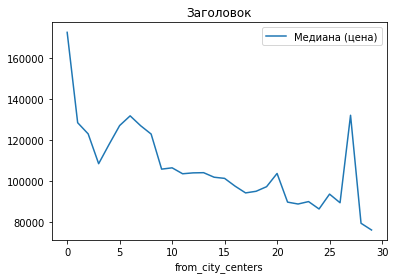

In [14]:
sorted_data2 = data[((data['locality_name'] =='Санкт-Петербург'))]
#sorted_data2.plot(x='from_city_centers', y='price_per_m', kind='scatter')
#sorted_data2.plot(x='from_city_centers', y='price_per_m',kind='area')
plt.show()

print(sorted_data2['locality_name'].unique())
data_pivot2 = sorted_data2.pivot_table(index = 'from_city_centers', values = 'price_per_m', aggfunc = ['median','mean'])
data_pivot2.columns = ['Медиана (цена)', 'Cреднее (цена)']
data_pivot2.plot( y='Медиана (цена)')
plt.title('Заголовок')
print(data_pivot2)
#print(sorted_data2.corr()) 


<div class="alert alert-info">построила график зависимости медианы цены от расстояния, до 17 примерно км в нем виден тренд, потом нет. Добавила это содержание в раздел и в выводы</div>


### Общий вывод

#### данные
данные сервиса Яндекс Недвижимость — архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах
#### основные задачи
выявить особенности и зависимости, которые существуют на рынке недвижимости
#### этапы и методы 
1) предобработка данных: восстановление потерь и пропусков, коррекция формата данных, поиск и удаление аномальных данных, поиск и удаление явных и неявных дубликатов.
2) дополнение данными на основе рассчетов: 
3) исследовательский анализ данных: 
#### выводы
По результататам исследование: рыночная цена недвижимости сложной многофакторной природы. 
 
Перечислю те факторы, по которым выявлено существенное влияние и их можно брать для расчетного алгоритма. 
-общий метраж
-метраж кухни
-метраж жилой площади
-тип этажа 
-локация (населенный пункт)
-год 
-расстояние от центра 

Подробнее: 
-общий метраж
-метраж кухни
-метраж жилой площади
В целом по мере роста этих характеритик растет цена объекта. Самое сильное влиятние у общего метража (total_area)
total_area - 0.653675, 
living_area - 0.566492, 
kitchen_area - 0.519869 

-тип этажа 
Самое существенное снижение цены, если этаж первый (без малого, на миллион.) Промежуточные значения у последнего этажа. 
другой       4850000.0
первый       3900000.0
последний    4300000.0
Локация (населеный пункт) играют роль 
Из десятки самых популярных по количеству продаж населенных пунктов 
самая высокая цена за квадратный метр: Санкт-Петербург      114849.008794
самая низкая цена за квадратный метр: Выборг                 58141.909153
Очень заметные отличия. Населенный пункт конечно может быть использован как коэффициент при рассчете цены. 

-год продажи. По годам очень заметные колебаний средней цены. Как вывод - для рассчета цены годится только свежая статистика. Данные по прошлым годам могут внести существенные искажения. 
-расстояние от центра: влияние на цену наблюдается в диаметере примерно 17.5 км от центра, дальше влияния нет

По срокам продажи объектов недвижимости 
до 45 дней - быстрый 
от 45 до 232 - нормальный 
больше 232 - долгий.
Видно влияние каких-то дополнительных факторов в р-не 45 дней и рядом. Для их понимания нужна информация о правилах размещения объявлений, рекламных активностях итд. 


**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод
